### Stock Market Prediction using Graph Neural Networks

In [1]:
from dataset.data import *
from models.gnn import *
from datetime import datetime

### Data Collection

In [ ]:
stock_path = '/Users/vivek/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2/stocks'
meta_path  = '/Users/vivek/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2/symbols_valid_meta.csv'
nasdaq100_path = '/Users/vivek/.cache/kagglehub/datasets/jacksoncrow/stock-market-dataset/versions/2/nasdaq_100.csv'

stock_data = NASDAQDataset(stock_path, meta_path, nasdaq100_path, "2014-01-01") # Collect all data after 2014-01-01
stock_data.read_data()

# Generate graphs for each day from the 30th data point (we need a minimum of 30 days to compute correlations)

for date in tqdm(stock_data.data['AAPL'].index[30:]):
    G = stock_data.daily_graph_generator(date)


In [ ]:
import random

# Read the gml files and create PyG data objects (required only once)

data_path = '/Users/vivek/Documents/PhD/UIUC/Fall24/CS598/Project/GNN-Stock-Market-Prediction/dataset/graphs'
data_list = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Select 1000 random elements from data_list

train_list = random.sample(data_list, 1000)
test_list = [file for file in data_list if file not in train_list]

train_loader = gnn_data_obj(train_list) # train on first 1000 graphs
test_loader = gnn_data_obj(test_list) # test on remaining graphs

# Save the train and test datasets

save_path = '/Users/vivek/Documents/PhD/UIUC/Fall24/CS598/Project/GNN-Stock-Market-Prediction/dataset/processed_dir/'
torch.save(test_loader, os.path.join(save_path, 'test_98.pt'))

In [4]:
# Load the processed data (saves time)

load_train_path = '/Users/vivek/Documents/PhD/UIUC/Fall24/CS598/Project/GNN-Stock-Market-Prediction/dataset/processed_dir/train_98.pt'
load_test_path = '/Users/vivek/Documents/PhD/UIUC/Fall24/CS598/Project/GNN-Stock-Market-Prediction/dataset/processed_dir/train_98.pt'

# Load the list of Data objects

train_loader = torch.load(load_train_path)
test_loader = torch.load(load_test_path)

In [5]:
class StockGAT(torch.nn.Module):

    # A 3-layer GAT for node regression
    
    def __init__(self):
        
        super(StockGAT, self).__init__()

        self.conv1 = GATConv(30, 128, heads = 2, concat= False, dropout = 0.3)
        self.conv2 = GATConv(128, 1, heads = 2, concat = False, dropout = 0.3)
        # self.conv3 = GATConv(32, 1, heads = 2, concat = False, dropout = 0.3, add_self_loops=True)        
    
    def forward(self, data):

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p = 0.3, training=self.training)
        
        # x = self.conv2(x, edge_index)
        # x = torch.relu(x)
        # x = F.dropout(x, p = 0.3, training=self.training)
        
        x = self.conv2(x, edge_index)

        return x

In [8]:
# # Check if there are edges other than self loops

# count = 0

# for data in train_loader:
    
#     G = nx.read_gml(data)

#     if len(G.edges) > len(G.nodes):
#         print(data)
#         count += 1

### Training

In [9]:
# Initialize the StockGNN model and optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

stock_gcn_model = StockGCN().to(device)
gcn_optimizer = torch.optim.Adam(stock_gcn_model.parameters(), lr=0.001, weight_decay=1e-5)

stock_gat_model = StockGAT().to(device)
gat_optimizer = torch.optim.Adam(stock_gat_model.parameters(), lr=0.0008, weight_decay=1e-5)

In [13]:
def eval_baseline(test_loader):

    total_mape_linr = 0
    total_mape_mov_avg = 0
    total_mape_exp_smoothing = 0
    total_mape_holt_winters = 0
    
    for data in test_loader:

        y = data.y

        # Compute the Mean Absolute Percentage Error

        mape_linr = float(torch.mean(torch.abs((y - data.linr_regr) / (y + 1e-7))))
        mape_mov_avg = float(torch.mean(torch.abs((y - data.mov_avg) / (y + 1e-7))))
        mape_exp_smoothing = float(torch.mean(torch.abs((y - data.exp_smoothing) / (y + 1e-7))))
        mape_holt_winters = float(torch.mean(torch.abs((y - data.holt_winters) / (y + 1e-7))))

        total_mape_linr += mape_linr
        total_mape_mov_avg += mape_mov_avg
        total_mape_exp_smoothing += mape_exp_smoothing
        total_mape_holt_winters += mape_holt_winters

    return total_mape_linr/len(test_loader), total_mape_mov_avg/len(test_loader), total_mape_exp_smoothing/len(test_loader), total_mape_holt_winters/len(test_loader)

mape_linr, mape_mov_avg, mape_exp_smoothing, mape_holt_winters = eval_baseline(test_loader)

print(f'MAPE Linear Regression: {mape_linr}')
print(f'MAPE Moving Average: {mape_mov_avg}')
print(f'MAPE Exponential Smoothing: {mape_exp_smoothing}')
print(f'MAPE Holt Winters: {mape_holt_winters}')

MAPE Linear Regression: 0.028885844497941435
MAPE Moving Average: 0.019437339208088815
MAPE Exponential Smoothing: 0.018369649408385157
MAPE Holt Winters: 0.014053557375911623


In [14]:
# TRAIN!

# train_loss, test_mape = train(stock_gcn_model, gcn_optimizer, train_loader, train_loader, 200)

train_loss_gat, test_mape_gat = train(stock_gat_model, gat_optimizer, train_loader, test_loader, 200)

  0%|          | 1/200 [00:02<08:20,  2.51s/it]

Epoch 000, Train Loss: 24543.4019, Val MAPE: 0.4139


  6%|▌         | 11/200 [00:27<07:08,  2.27s/it]

Epoch 010, Train Loss: 100.7195, Val MAPE: 0.0370


 10%|█         | 21/200 [00:48<06:17,  2.11s/it]

Epoch 020, Train Loss: 82.0322, Val MAPE: 0.0219


 16%|█▌        | 31/200 [01:11<06:11,  2.20s/it]

Epoch 030, Train Loss: 72.2193, Val MAPE: 0.0168


 20%|██        | 41/200 [01:31<05:23,  2.03s/it]

Epoch 040, Train Loss: 69.0580, Val MAPE: 0.0156


 26%|██▌       | 51/200 [01:52<05:03,  2.04s/it]

Epoch 050, Train Loss: 64.6979, Val MAPE: 0.0155


 30%|███       | 61/200 [02:12<04:41,  2.03s/it]

Epoch 060, Train Loss: 60.9714, Val MAPE: 0.0156


 36%|███▌      | 71/200 [02:34<04:51,  2.26s/it]

Epoch 070, Train Loss: 58.3972, Val MAPE: 0.0158


 40%|████      | 81/200 [02:56<04:26,  2.24s/it]

Epoch 080, Train Loss: 56.1990, Val MAPE: 0.0159


 46%|████▌     | 91/200 [03:18<04:03,  2.23s/it]

Epoch 090, Train Loss: 54.8592, Val MAPE: 0.0162


 50%|█████     | 101/200 [03:40<03:39,  2.22s/it]

Epoch 100, Train Loss: 52.9819, Val MAPE: 0.0162


 56%|█████▌    | 111/200 [04:01<03:02,  2.06s/it]

Epoch 110, Train Loss: 51.8000, Val MAPE: 0.0163


 60%|██████    | 121/200 [04:24<03:10,  2.41s/it]

Epoch 120, Train Loss: 49.6450, Val MAPE: 0.0164


 66%|██████▌   | 131/200 [04:46<02:26,  2.13s/it]

Epoch 130, Train Loss: 50.1073, Val MAPE: 0.0165


 70%|███████   | 141/200 [05:11<02:30,  2.55s/it]

Epoch 140, Train Loss: 49.4193, Val MAPE: 0.0165


 76%|███████▌  | 151/200 [05:32<01:44,  2.14s/it]

Epoch 150, Train Loss: 48.9712, Val MAPE: 0.0166


 80%|████████  | 161/200 [05:56<01:29,  2.30s/it]

Epoch 160, Train Loss: 48.5776, Val MAPE: 0.0138


 86%|████████▌ | 171/200 [06:18<01:01,  2.11s/it]

Epoch 170, Train Loss: 48.1965, Val MAPE: 0.0166


 90%|█████████ | 181/200 [06:39<00:40,  2.13s/it]

Epoch 180, Train Loss: 48.7180, Val MAPE: 0.0182


 96%|█████████▌| 191/200 [07:00<00:18,  2.05s/it]

Epoch 190, Train Loss: 47.0853, Val MAPE: 0.0172


100%|██████████| 200/200 [07:19<00:00,  2.20s/it]


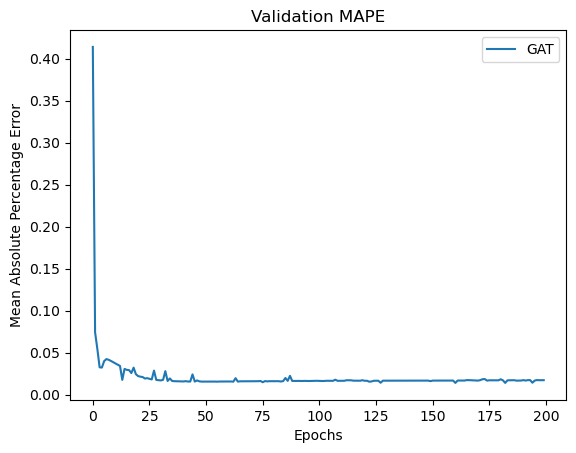

In [15]:
# Plot the validation MAPE

plt.title('Validation MAPE')
# plt.plot(test_mape, label = 'GCN')
plt.plot(test_mape_gat, label = 'GAT')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()